In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns 
import geopandas as gpd
import pandas as pd 
import numpy as np
import requests
import shapely
import pickle
import progressbar
import geopy.distance
from shapely.geometry import Point, Polygon, LineString 
from shapely.ops import nearest_points
from shapely.ops import transform
from shapely import geometry, ops
from functools import partial
from itertools import combinations
import geopandas as gpd
import pyproj
import os
from scipy.sparse import lil_matrix
import itertools
import warnings
warnings.simplefilter('ignore')
import random
from random import choice, randint
import timeit
import time
from time import time
import threading
from multiprocessing import Pool, Process
from joblib import Parallel, delayed
import pulp as plp
from pulp import *

C:\Users\alexa\anaconda3\envs\ox\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
#Create 25 nodes in network with node weights
nodeweights = [0,.05, .082, .023, .032, .023, .003, .007, .061, .013, .052, .013, .052, .005, .059, .017, .022, .038, .104, .07, .036, .018, .073, .011, .134, .002]
multiplied_list = [element * 1000 for element in nodeweights]
G = nx.Graph()
for i in range(1,26):
    G.add_node(i, weight=multiplied_list[i])
    
#Add edges and lengths, manual job
G.add_edge(1,2, length=4) 
G.add_edge(1,5, length=5) 
G.add_edge(2, 4, length=4)
G.add_edge(2, 3, length=3)
G.add_edge(3, 9, length=4)
G.add_edge(3, 4, length=4)
G.add_edge(4, 5, length=3)
G.add_edge(4, 9, length=7)
G.add_edge(4, 7, length=5)
G.add_edge(4, 8, length=5)
G.add_edge(5, 6, length=5)
G.add_edge(5, 7, length=5)
G.add_edge(6, 7, length=3)
G.add_edge(7, 8, length=3)
G.add_edge(7, 12, length=9)
G.add_edge(7, 11, length=8)
G.add_edge(8, 9,length= 6)
G.add_edge(8, 10, length=6)
G.add_edge(8, 11, length=7)
G.add_edge(8, 13, length=7)
G.add_edge(9, 10, length=6)
G.add_edge(10, 13, length=6)
G.add_edge(10, 14, length=3)
G.add_edge(11, 12, length=2)
G.add_edge(11, 13, length=3)
G.add_edge(11, 16, length=7)
G.add_edge(12, 15, length=4)
G.add_edge(12, 16, length=4)
G.add_edge(13, 14, length=7)
G.add_edge(13, 19, length=4)
G.add_edge(14, 19, length=7)
G.add_edge(14, 21, length=2)
G.add_edge(14, 22, length=4)
G.add_edge(15, 16, length=4)
G.add_edge(16, 17, length=4)
G.add_edge(17, 18, length=3)
G.add_edge(17, 19, length=3)
G.add_edge(18, 20, length=3)
G.add_edge(19, 20, length=3)
G.add_edge(20, 21, length=2)
G.add_edge(22, 23, length=3)
G.add_edge(23, 24, length=3)
G.add_edge(24, 25, length=8)
#check all lengths and weights. 
G = G.to_undirected()

In [3]:
#Normalize node sizes
node_size = []
for i in G.nodes:
    node_size.append(G.nodes[i]['weight'])

norm_node_size = []
for i in node_size:
    norm_node_size.append(i*300/20)

In [4]:
keys = []
vals = []

for i in G.edges:
    keys.append(i)
    vals.append(G.edges[i]['length'])
zip_iter = zip(keys,vals)
edge_labels = dict(zip_iter)

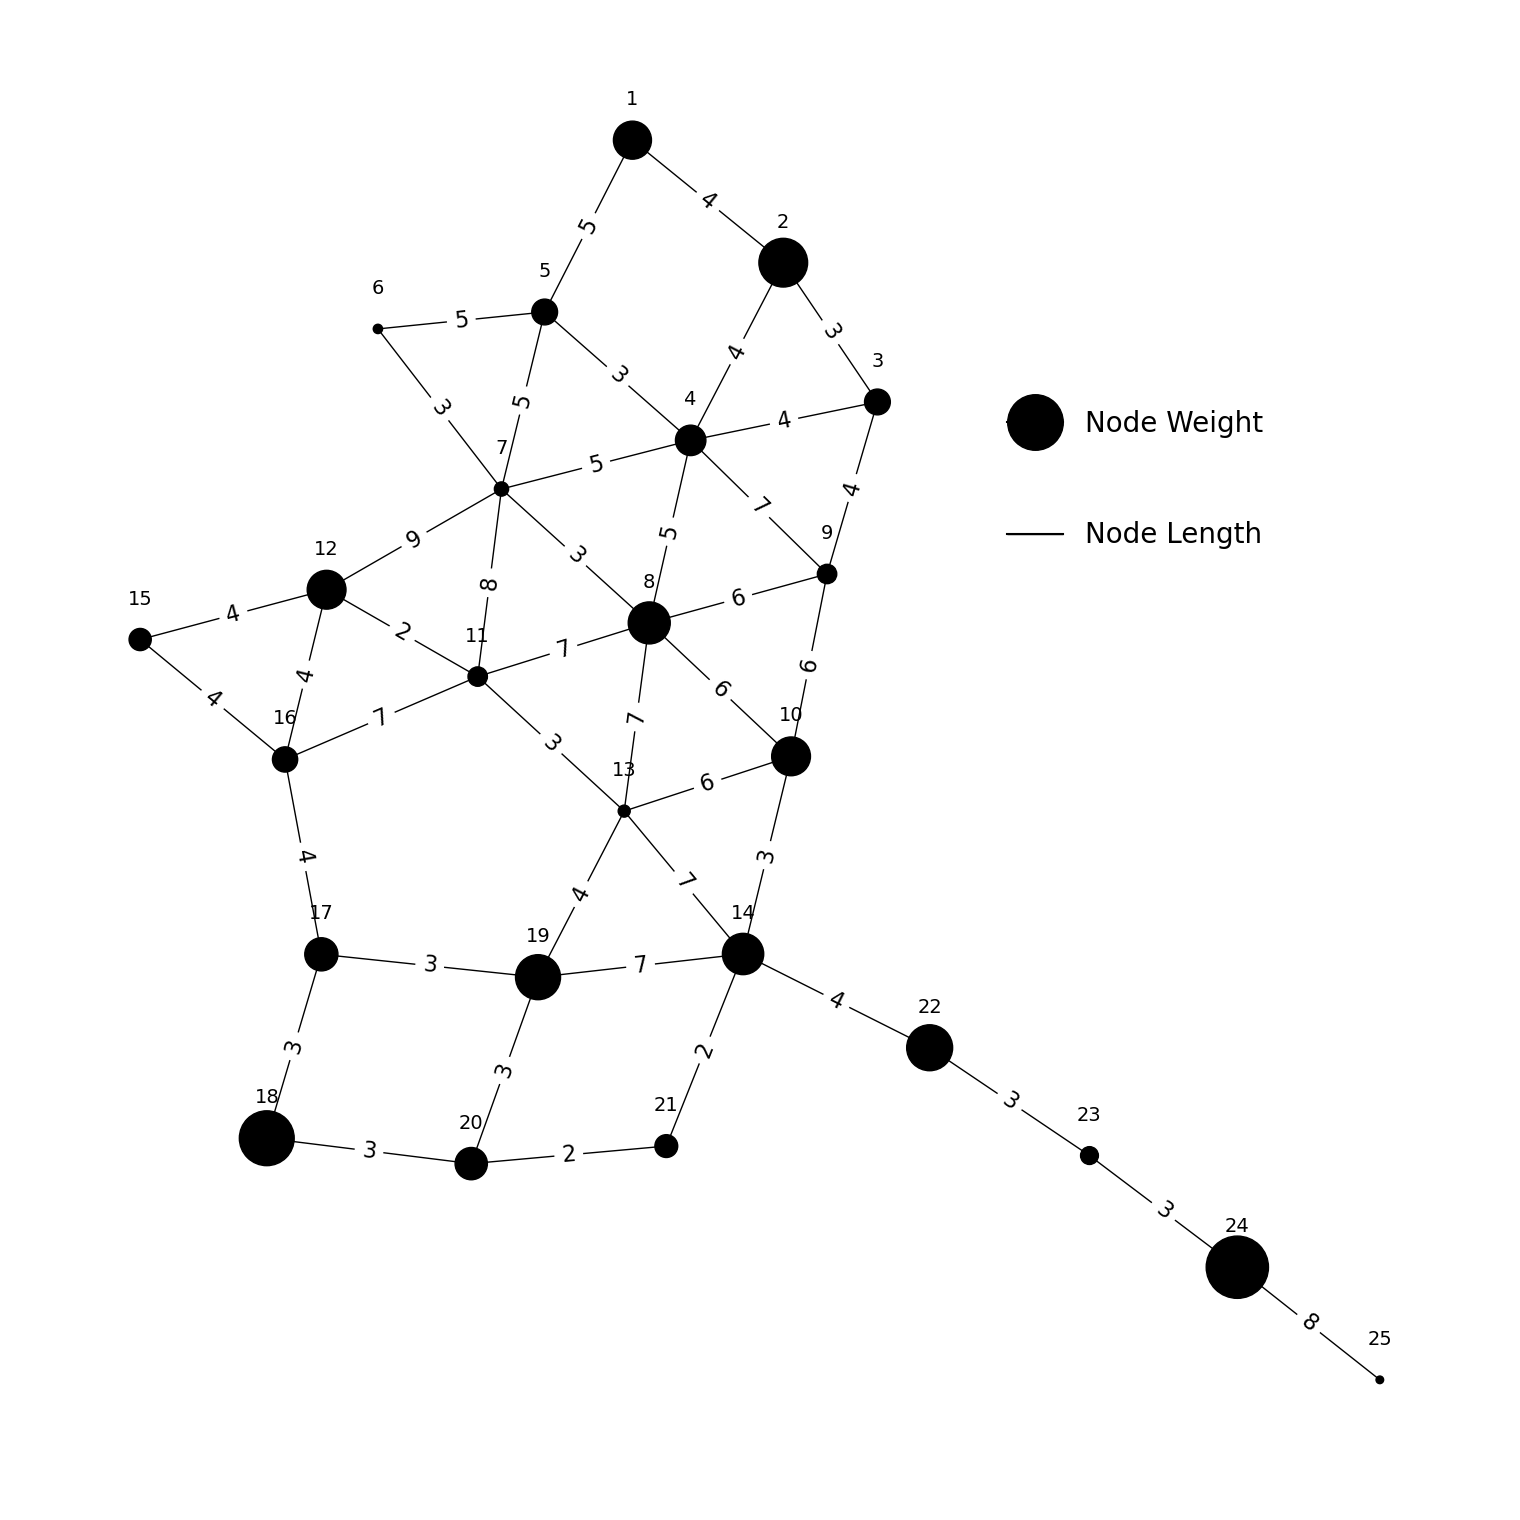

In [5]:
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(15,15), dpi=100)

#Draw network + node numbers
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=norm_node_size, node_color='black', alpha=1.0)




#Edges
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=16, font_color="black")

#Add Node weights text
for i in G.nodes:
    x,y=pos[i]
    plt.text(x,y+0.05,s=i, bbox=dict(facecolor='white', alpha=0),horizontalalignment='center', fontsize=14)
    
plt.plot([], [], color="black", markersize = 40, marker='o', label = "Node Weight")
plt.plot([], [], color="black", markersize = 40, marker='_', label = "Node Length")
plt.legend(labelspacing = 3, loc='upper center', bbox_to_anchor=(0.75, 0.75), frameon = False, prop={'size':20})

plt.savefig('Data/Figures/TestNetwork.png')
plt.show()

In [7]:
#Define All functions used
def create_combs(df, Totalrange):

    #Create all possible combinations of node from path i
    allvalid = []
    for i in df.index:
        path = df.iloc[i]['path']
        allcombs = []
        for j in range(1,len(path)+1):
            combs = combinations(path,j)
            for k in combs:
                allcombs.append(list(k))
        validcombs = []
        for k in allcombs: #For each combination
            origin = path[0]
            destination = path[-1]
            revpath = path[::-1][1:]
            fullpath = path+revpath

            if origin in k:
                rem_range = Totalrange
            else:
                rem_range = Totalrange/2
            for j in range(len(fullpath)+1):
                try:
                    a = fullpath[j]
                    b = fullpath[j+1]

                    length = G.edges[a,b]['length']

                    rem_range -= length

                    if rem_range <0:
                        break
                    elif b == destination & destination in k:
                        validcombs.append(k)
                        break
                    elif b == origin:
                        validcombs.append(k)
                        break
                    elif b in k:
                        rem_range = Totalrange
                except IndexError:
                    pass
        allvalid.append(validcombs)
        
        #Remove supersets
        allvalidnosuper = []

        for super in allvalid:
            subset=[s for s in super if not any(set(s).issuperset(set(i)) and len(s)>len(i) for i in super)]
            allvalidnosuper.append(subset)
    return allvalidnosuper


def Objectivefunction(FacilitiesList, df, Totalrange):
    CoveredObjectiveValue = 0
    facilities = FacilitiesList
    
    #Loop through every path
    for j in range(len(df)):
        path = df.iloc[j]['path']
        NodeInFacilityListExistInPath = False
        for node in path:
            if node in facilities:
                NodeInFacilityListExistInPath = True
                break
        if NodeInFacilityListExistInPath == True: #Only evaluate if at least one facility is on the path
            #Check if facilities can refuel path
            if path[0] in facilities:
                rem_range = Totalrange
            else:
                rem_range = Totalrange/2
                
                #Start looping through the path going first from origin to the destination:
            revpath = path[::-1][1:]
            fullpath = path+revpath
                
            for i in range(len(fullpath)+1):
                try:
                    a = fullpath[i]
                    b = fullpath[i+1]
                    length = G.edges[a,b]['length']
                    rem_range -= length

                    if rem_range <0:
                        break
                    elif b == path[-1] & path[-1] in facilities:
                        CoveredObjectiveValue += df.iloc[j]['flow']
                        break
                    elif b == path[0]:
                        CoveredObjectiveValue += df.iloc[j]['flow']
                        break
                    elif b in facilities:
                        rem_range = Totalrange
                except IndexError:
                    pass
    return CoveredObjectiveValue

def greedy(p, k, df, Totalrange):
    start = time()
    selectedFacilities = []
    for z in range(p):
        CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList.append(facility)

                TempObjectiveValue = Objectivefunction(FacilitiesList, df, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility
        selectedFacilities.append(CurrentMaxFacility)
    end = time()
    final = end-start
    return selectedFacilities, CurrentMaxObjectiveValue, final



def greedysub(p, k, df, Totalrange, sub_iterations):
    start = time()
    selectedFacilities = []
    for z in range(p):
        CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            # FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList = selectedFacilities.copy()
                FacilitiesList.append(facility)
                TempObjectiveValue = Objectivefunction(FacilitiesList, df, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility
        selectedFacilities.append(CurrentMaxFacility)
        
        for i in range(sub_iterations):
            SubFacilityIndex = list(np.setdiff1d(k,selectedFacilities))
            SubMaxObjectiveValue = 0
            SubMaxFacility = 0
            IndexBeingSubstituted = 0
            for index in range(len(selectedFacilities)):
                if selectedFacilities[index] != CurrentMaxFacility:
                    TempFacilities = selectedFacilities.copy()
                    TempFacilities.remove(selectedFacilities[index])
                    for Subfacility in SubFacilityIndex:
                        SubArray = TempFacilities.copy()
                        SubArray.append(Subfacility)
                        CurrentObjectiveValue = Objectivefunction(SubArray, df, Totalrange)
                        if CurrentObjectiveValue > SubMaxObjectiveValue:
                            SubMaxObjectiveValue = CurrentObjectiveValue
                            SubMaxFacility = Subfacility
                            IndexBeingSubstituted = index                        
            
            if SubMaxObjectiveValue > CurrentMaxObjectiveValue: 
                selectedFacilities[IndexBeingSubstituted] = SubMaxFacility
                CurrentMaxObjectiveValue = SubMaxObjectiveValue
                CurrentMaxFacility = SubMaxFacility
            else:
                break
            
    end = time()
    time1 = end-start
    return selectedFacilities, CurrentMaxObjectiveValue, time1

def Union(father, mother):
    unionlist= list(set(father) | set(mother))
    return unionlist

#Define crossover
def crossover(f,p,Totalrange, union):
    """
    Performs the greedy deletion crossover algorithm which is a part of the genetic algorithm
    
    input:
    f: iterator, f goes from 0 to length of union
    union: unioned chromosones from father and mother
    """
    
    A = union[f]
    totalgenes = len(A)
    for i in range(totalgenes, p, -1):
        CurrentMaxObjectiveValue = 0
        CurrentMaxIndex = 0
        for j in range(len(A)):
            TempFacilities = A.copy()
            TempFacilities.pop(j)
            TempObjectiveValue = Objectivefunction(TempFacilities, df, Totalrange)
            if TempObjectiveValue > CurrentMaxObjectiveValue:
                CurrentMaxObjectiveValue = TempObjectiveValue
                CurrentMaxIndex = j
        A.pop(CurrentMaxIndex)
    children1 = A
    return children1


#Define the genetic algorithm

def geneticv2(k, p, pop_limit, mutation_freq, nr_gen, df, Totalrange, ObjectiveMILP):
    """
    Genetic Algorithm. Algorithm that is modeled after the process of evolution. Starts with multiple sets of chromosones (random solutions) forming a population. Each chromosone consists of p genes (facilities). 
    For each generation, better solutions are produced until the maximum number of generations are reached of if the algorithm converges.
    
    Input:
    k: List of candidate locations
    p: Number of facilities to be located
    pop_limit: Starting population/population limit
    mutation_freq: Chance of gene mutation
    nr_gen: Number of generations
    df: dataframe containing Origin, Destination, path, total length of path and the flow of each path
    Totalrange: Full range of the electric vehicles when fully recharged
    """
    p=p
    #Initialize the maximum objective value and a list of all maximum objective values for each generation. Also initiate timer so we can measure the time spent
    MaxObjectiveValue = 0
    AllObjectiveValues = []
    start = time()
    #Initialize an empty list where the facilities that captures the most flow are stored
    best_pop = []
    
    #Initialize population
    population = []
    for i in range(pop_limit):
        combos = random.sample(k,p)
        population.append(combos)
    
    #Selecting the parents
    for x in range(nr_gen):
        mother = random.sample(population, round(pop_limit/2))
        for i in mother: 
            population.remove(i)
            
        father = population.copy()   

        #Union chromosones of mother and father
        iterations = len(father)
        union = [] 
        for i in range(iterations):
            temp = Union(father[i], mother[i])
            union.append(temp)
        #Greedy deletion crossover algorithm for each cromosone. Calls the crossover function and utilizes all available cores. This causes the algorithm to run about 200% faster
        # if __name__ == "__main__":
        children = Parallel(n_jobs=-1)(delayed(crossover)(f,p,Totalrange ,union) for f in range(len(union)))

        
        #New member selection. Select the two best out of children, mother and father, each with a length of pop_limit/2. Population length should then be = pop_limit
        population = []
        objectivevalues = []
        for i in range(round(pop_limit/2)):
            MotherValue = Objectivefunction(mother[i], df, Totalrange)
            FatherValue = Objectivefunction(father[i], df, Totalrange)
            ChildrenValue = Objectivefunction(children[i], df, Totalrange)
            minValue = min(MotherValue, FatherValue, ChildrenValue)
            maxValue = max(MotherValue, FatherValue, ChildrenValue)
            if MotherValue == minValue:
                population.append(list(father[i])) 
                population.append(list(children[i]))
                objectivevalues.append(FatherValue)
                objectivevalues.append(ChildrenValue)
            elif FatherValue == minValue:
                population.append(list(mother[i]))
                population.append(list(children[i]))
                objectivevalues.append(MotherValue)
                objectivevalues.append(ChildrenValue)            
            elif ChildrenValue == minValue:
                population.append(list(mother[i]))
                population.append(list(father[i]))
                objectivevalues.append(FatherValue)
                objectivevalues.append(MotherValue)
            
            #Picks the highest scoring chromosone and stores it as the best solution for current generation
            if MotherValue == maxValue:
                if MotherValue > MaxObjectiveValue:
                    MaxObjectiveValue = MotherValue
                    best_pop = mother[i]

            elif FatherValue == maxValue:
                if FatherValue > MaxObjectiveValue:
                    MaxObjectiveValue = FatherValue
                    best_pop = father[i]

            elif ChildrenValue == maxValue:
                if ChildrenValue > MaxObjectiveValue:
                    MaxObjectiveValue = ChildrenValue
                    best_pop = children[i]               
            
        #Mutation, do not mutate last iteration
        if x < nr_gen:
            for i in range(len(population)): #For each Chromosome
                if random.random() < mutation_freq:
                    #If a chrosome is chosen one random gene in it will mutate
                    # population[i][random.randint(0,(p-1))] = random.randint(0,len(k))
                    j = random.randint(0, p-1)
                    population[i][j] = random.sample(k,1)[0]

        print("Generation:", (x+1))
        print("Facilities that captures the most flow:", best_pop, "Flow:", MaxObjectiveValue)
        AllObjectiveValues.append(MaxObjectiveValue)

        #If best_pop flow has not improved for four generations, we assume that it has converged, given that it has run for at least 5 generations.
        if len(AllObjectiveValues) > 5:
            if AllObjectiveValues[x] == AllObjectiveValues[(x-1)] == AllObjectiveValues[x-2] == AllObjectiveValues[x-3]:
                print("Convergence reached at gen:",(x+1))
                #print(round(MaxObjectiveValue/df.sum()[-1]*100,2),"% of flow captured")
                end = time()
                runtime = end-start
                #print("runtime",round(end-start,1),"seconds")
                return best_pop, MaxObjectiveValue, runtime
            
        #If algorithm finds the optimal solution
        elif MaxObjectiveValue == ObjectiveMILP:
            end = time()
            runtime = end-start
            return best_pop, MaxObjectiveValue, runtime
            
    #If no convergence has occured, the algorithm will finish once it has completed all generations and return the best solution it could find
    print("Maximum number of generations reached")
    #print("Flow captured:", MaxObjectiveValue)
    end = time()
    runtime = (end-start)
    #print("runtime",round(end-start,1),"seconds")
    return best_pop, MaxObjectiveValue, runtime


def comparisons(p,df,G,Totalranges):
    """
    Compares how well greedy-adding with substitution and GA works compared to the optimal solution
    """
    sub_iter = [0,1,2,3]
    Totalfacs = list(G.nodes)
    pop_limit = 50
    mutation_freq = 0.1
    nr_gen = 20
    
    #Store totalflow
    totalflow = df['flow'].sum()
    #Create emppty lists that will go into final df
    data = []
    
    #Loop through all vehicle ranges
    for vRange in Totalranges:
        for facs1 in p:

            #Start by creating all possible combinations
            df['combinations']= create_combs(df, vRange)
            master_df = df.copy()

            #Create the master list H: List of all combinations
            H = []
            for i in master_df.combinations:
                for k in i:
                    H.append(k)

            H.sort()
            H = list(H for H,_ in itertools.groupby(H))

            #Define K
            K = list(set(list(master_df.fromnode)+list(master_df.tonode)))

            #create bqh and ahk
            columns=list(i for i in range(len(H)))
            b_qh=pd.DataFrame(columns = columns, index=master_df.index)
            b_qh.fillna(0,inplace=True)

            a_hk=pd.DataFrame(columns = K, index=range(len(H)))
            a_hk.fillna(0, inplace=True)

            for i in master_df.index:
                q = master_df.combinations[i]
                for count,h in enumerate(H):
                    if h in q:
                        b_qh[count][i]=1

            for count,h in enumerate(H):
                for i in K:
                    for fac in h:
                        if fac == i:
                            a_hk[i][count]=1



            #Turn all parameters into dictionary objects before using Pulp optimizer
            #a_hk
            keys = []
            vals = []
            for h in a_hk.index:
                for k in a_hk:
                    h_k = (h,k)
                    val = a_hk.iloc[h][k]
                    keys.append(h_k)
                    vals.append(val)
            zip_iter = zip(keys,vals)
            a_hk_fin = dict(zip_iter)
            a = a_hk_fin
            #b_hk
            keys = []
            vals = []
            for q in b_qh.index:
                for h in b_qh:
                    qh = (q,h)
                    val = b_qh.iloc[q,h]
                    keys.append(qh)
                    vals.append(val)
            zip_iter = zip(keys,vals)
            b = dict(zip_iter)

            #K
            keys = [i for i in range(1,26)]
            vals = [i for i in range(1,26)]
            zip_iter = zip(keys,vals)
            K = dict(zip_iter)

            #H
            keys = []
            vals = []
            for i in range(len(H)):
                keys.append(i)
                vals.append(H[i])
            zip_iter = zip(keys,vals)
            H = dict(zip_iter)

            #Q and fq                
            keysQ = []
            valsQ = []
            keys = []
            flows = []
            for i in master_df.index:
                fromnode = master_df.iloc[i]['fromnode']
                tonode = master_df.iloc[i]['tonode']
                fromto = [fromnode,tonode]
                path = master_df.iloc[i]['path']
                flow = master_df.iloc[i]['flow']
                keysQ.append(i)
                keys.append(i)
                valsQ.append(fromto)
                flows.append(flow)


            zip_iter = zip(keysQ,valsQ)
            Q = dict(zip_iter)
            set_Q = range(len(Q))

            zip_iter = zip(keys,flows)
            fq = dict(zip_iter)

            #Setting problem variable
            prob = plp.LpProblem("CSLocation", plp.LpMaximize)

            #Define variables
            y_vars  = plp.LpVariable.dicts("y", Q, 0,1, cat="Integer")
            x_vars  = plp.LpVariable.dicts("x", K, 0,1, plp.LpBinary)
            v_vars  = plp.LpVariable.dicts("v", H, 0,1, cat="Integer")

            #Define Objective Function
            prob += plp.lpSum(fq[q]*y_vars[q] for q in Q)

            #Define Constraints

            for q in Q:
                prob += plp.lpSum(b[(q,h)]*v_vars[h] for h in H) >= y_vars[q]


            for k in K:
                for h in H:
                     prob+= x_vars[k] >= (v_vars[h]*a[(h,k)])   

            prob += plp.lpSum(x_vars) ==facs1
            
            #Solve
            prob.solve()
            #Store Objectivevalue
            ObjectiveMILP = prob.objective.value()
            opt_sol_val = (ObjectiveMILP/totalflow)*100
            print(ObjectiveMILP)

            #Solve with same vehicle range and p for heuristic algorithms
            #GA
            k = list(G.nodes)
            geneticalgo = geneticv2(k, facs1, pop_limit, mutation_freq, nr_gen, master_df, vRange, ObjectiveMILP)
            ObjectiveGA = round(geneticalgo[1],2)
            OptgapGA = round(1-(ObjectiveGA/ObjectiveMILP),2)
            OptgapGA = round((ObjectiveMILP-ObjectiveGA)/ObjectiveMILP,2)
            data1 = [vRange,facs1,opt_sol_val,OptgapGA]
            
            #Greedy sub 1,2,3
            for sub in sub_iter:
                greedysubalgo = greedysub(facs1, k, master_df, vRange, sub)
                Objectivegreedysub = round(greedysubalgo[1],2)
                # OptgapGreedy = round(1-(Objectivegreedysub/ObjectiveMILP),2)
                OptgapGreedy = round((ObjectiveMILP-Objectivegreedysub)/ObjectiveMILP,2)
                data1.append(OptgapGreedy)
            data.append(data1)
            
    #Create df containing results       
    final_df = pd.DataFrame(data, columns = ['Vehicle Range', 'p','Optimal solution','GA','Greedy','Greedy sub 1', 'Greedy Sub 2', 'Greedy Sub 3'])        
    
    return final_df

In [8]:
###########################################################
###########################################################
###########################################################
### Next part compares GA and greedy to optimal solution ##
###########################################################
###########################################################
###########################################################

#Create OD Pairs, flow, paths etc
OD_nodes = [i for i in range(1,26)]
comb= combinations(OD_nodes, 2)
fromnode = []
tonode = []
path = []
flow = []
totallength = []
for i in list(comb):
    fromm = i[0]
    too = i[1]
    fromnode.append(fromm)
    tonode.append(too)
    toto = nx.shortest_path(G, fromm, too, 'length')
    sdist = nx.shortest_path_length(G, fromm, too, 'length')
    totallength.append(sdist)
    path.append(toto)
    ODij = ((G.nodes[fromm]['weight'] * G.nodes[too]['weight'])/sdist)**1.5
    flow.append(ODij)

d = {'fromnode':fromnode, 'tonode':tonode, 'path':path, 'totallength':totallength, 'flow':flow}
df = pd.DataFrame(d)

In [10]:
pvals = [5,10,15,20,25]
Ranges = [4,10,16]

comparison_df = comparisons(pvals,df,G,Ranges)

256647.42421751693
Generation: 1
Facilities that captures the most flow: [17, 18, 19, 20, 21] Flow: 256647.42421751693
548075.9996609391
Generation: 1
Facilities that captures the most flow: [8, 12, 14, 17, 18, 19, 20, 22, 23, 24] Flow: 463516.60497664317
Generation: 2
Facilities that captures the most flow: [12, 14, 15, 17, 18, 19, 20, 22, 23, 24] Flow: 467025.5494065663
Generation: 3
Facilities that captures the most flow: [10, 14, 16, 17, 18, 19, 20, 22, 23, 24] Flow: 548075.9996609391
648457.1055989388
Generation: 1
Facilities that captures the most flow: [1, 2, 3, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24] Flow: 635005.1963268565
Generation: 2
Facilities that captures the most flow: [1, 2, 3, 4, 10, 12, 14, 16, 17, 18, 19, 20, 22, 23, 24] Flow: 648457.1055989388
682930.6009984722
Generation: 1
Facilities that captures the most flow: [1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24] Flow: 682930.6009984722
684815.6499868972
Generation: 1
Facilities tha

In [12]:
comparison_df

,Vehicle Range,p,Optimal solution,GA,Greedy,Greedy sub 1,Greedy Sub 2,Greedy Sub 3
0,4,5,26.344538,0.0,0.70,0.00,0.00,0.00
1,4,10,56.259318,-0.0,0.42,0.42,0.42,0.21
2,4,15,66.563313,-0.0,0.38,0.38,0.38,-0.00
3,4,20,70.101975,0.0,0.40,0.33,0.22,0.00
4,4,25,70.295473,-0.0,-0.00,-0.00,-0.00,-0.00
5,10,5,66.809177,0.0,0.03,0.00,0.00,0.00
6,10,10,92.736302,0.0,0.02,0.00,0.00,0.00
7,10,15,99.712160,0.0,0.00,0.00,0.00,0.00
8,10,20,100.000000,0.0,0.00,0.00,0.00,0.00
9,10,25,100.000000,0.0,0.00,0.00,0.00,0.00


In [171]:
#Temporarily change greedy and greedysub

def greedy(p, k, df, Totalrange):
    alltimes = []
    selectedFacilities = []
    for z in range(p):
        start = time()
        CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList.append(facility)

                TempObjectiveValue = Objectivefunction(FacilitiesList, df, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility
        selectedFacilities.append(CurrentMaxFacility)
        end = time()
        final = end-start
        alltimes.append(final)
    return selectedFacilities, CurrentMaxObjectiveValue, alltimes

def greedysub(p, k, df, Totalrange, sub_iterations):
    start = time()
    selectedFacilities = []
    iterationTime = []
    for z in range(p):
        time10 = time()
        CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            # FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList = selectedFacilities.copy()
                FacilitiesList.append(facility)
                TempObjectiveValue = Objectivefunction(FacilitiesList, df, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility
        selectedFacilities.append(CurrentMaxFacility)
        
        for i in range(sub_iterations):
            SubFacilityIndex = list(np.setdiff1d(k,selectedFacilities))
            SubMaxObjectiveValue = 0
            SubMaxFacility = 0
            IndexBeingSubstituted = 0
            for index in range(len(selectedFacilities)):
                if selectedFacilities[index] != CurrentMaxFacility:
                    TempFacilities = selectedFacilities.copy()
                    TempFacilities.remove(selectedFacilities[index])
                    for Subfacility in SubFacilityIndex:
                        SubArray = TempFacilities.copy()
                        SubArray.append(Subfacility)
                        CurrentObjectiveValue = Objectivefunction(SubArray, df, Totalrange)
                        if CurrentObjectiveValue > SubMaxObjectiveValue:
                            SubMaxObjectiveValue = CurrentObjectiveValue
                            SubMaxFacility = Subfacility
                            IndexBeingSubstituted = index                        
            
            if SubMaxObjectiveValue > CurrentMaxObjectiveValue: 
                selectedFacilities[IndexBeingSubstituted] = SubMaxFacility
                CurrentMaxObjectiveValue = SubMaxObjectiveValue
                CurrentMaxFacility = SubMaxFacility
            else:
                break
        time20 = time()
        final = time20-time10
        iterationTime.append(final)
    end = time()
    time1 = end-start
    return selectedFacilities, CurrentMaxObjectiveValue, iterationTime

In [172]:
#runtimes for greedy

a, b, greedyruntimes =greedy(i,k,df,25)

a, b, greedy1runtimes = greedysub(i, k, df, 25, 1)

a, b, greedy2runtimes = greedysub(i, k, df, 25, 2)

a, b, greedy3runtimes = greedysub(i, k, df, 25, 3)


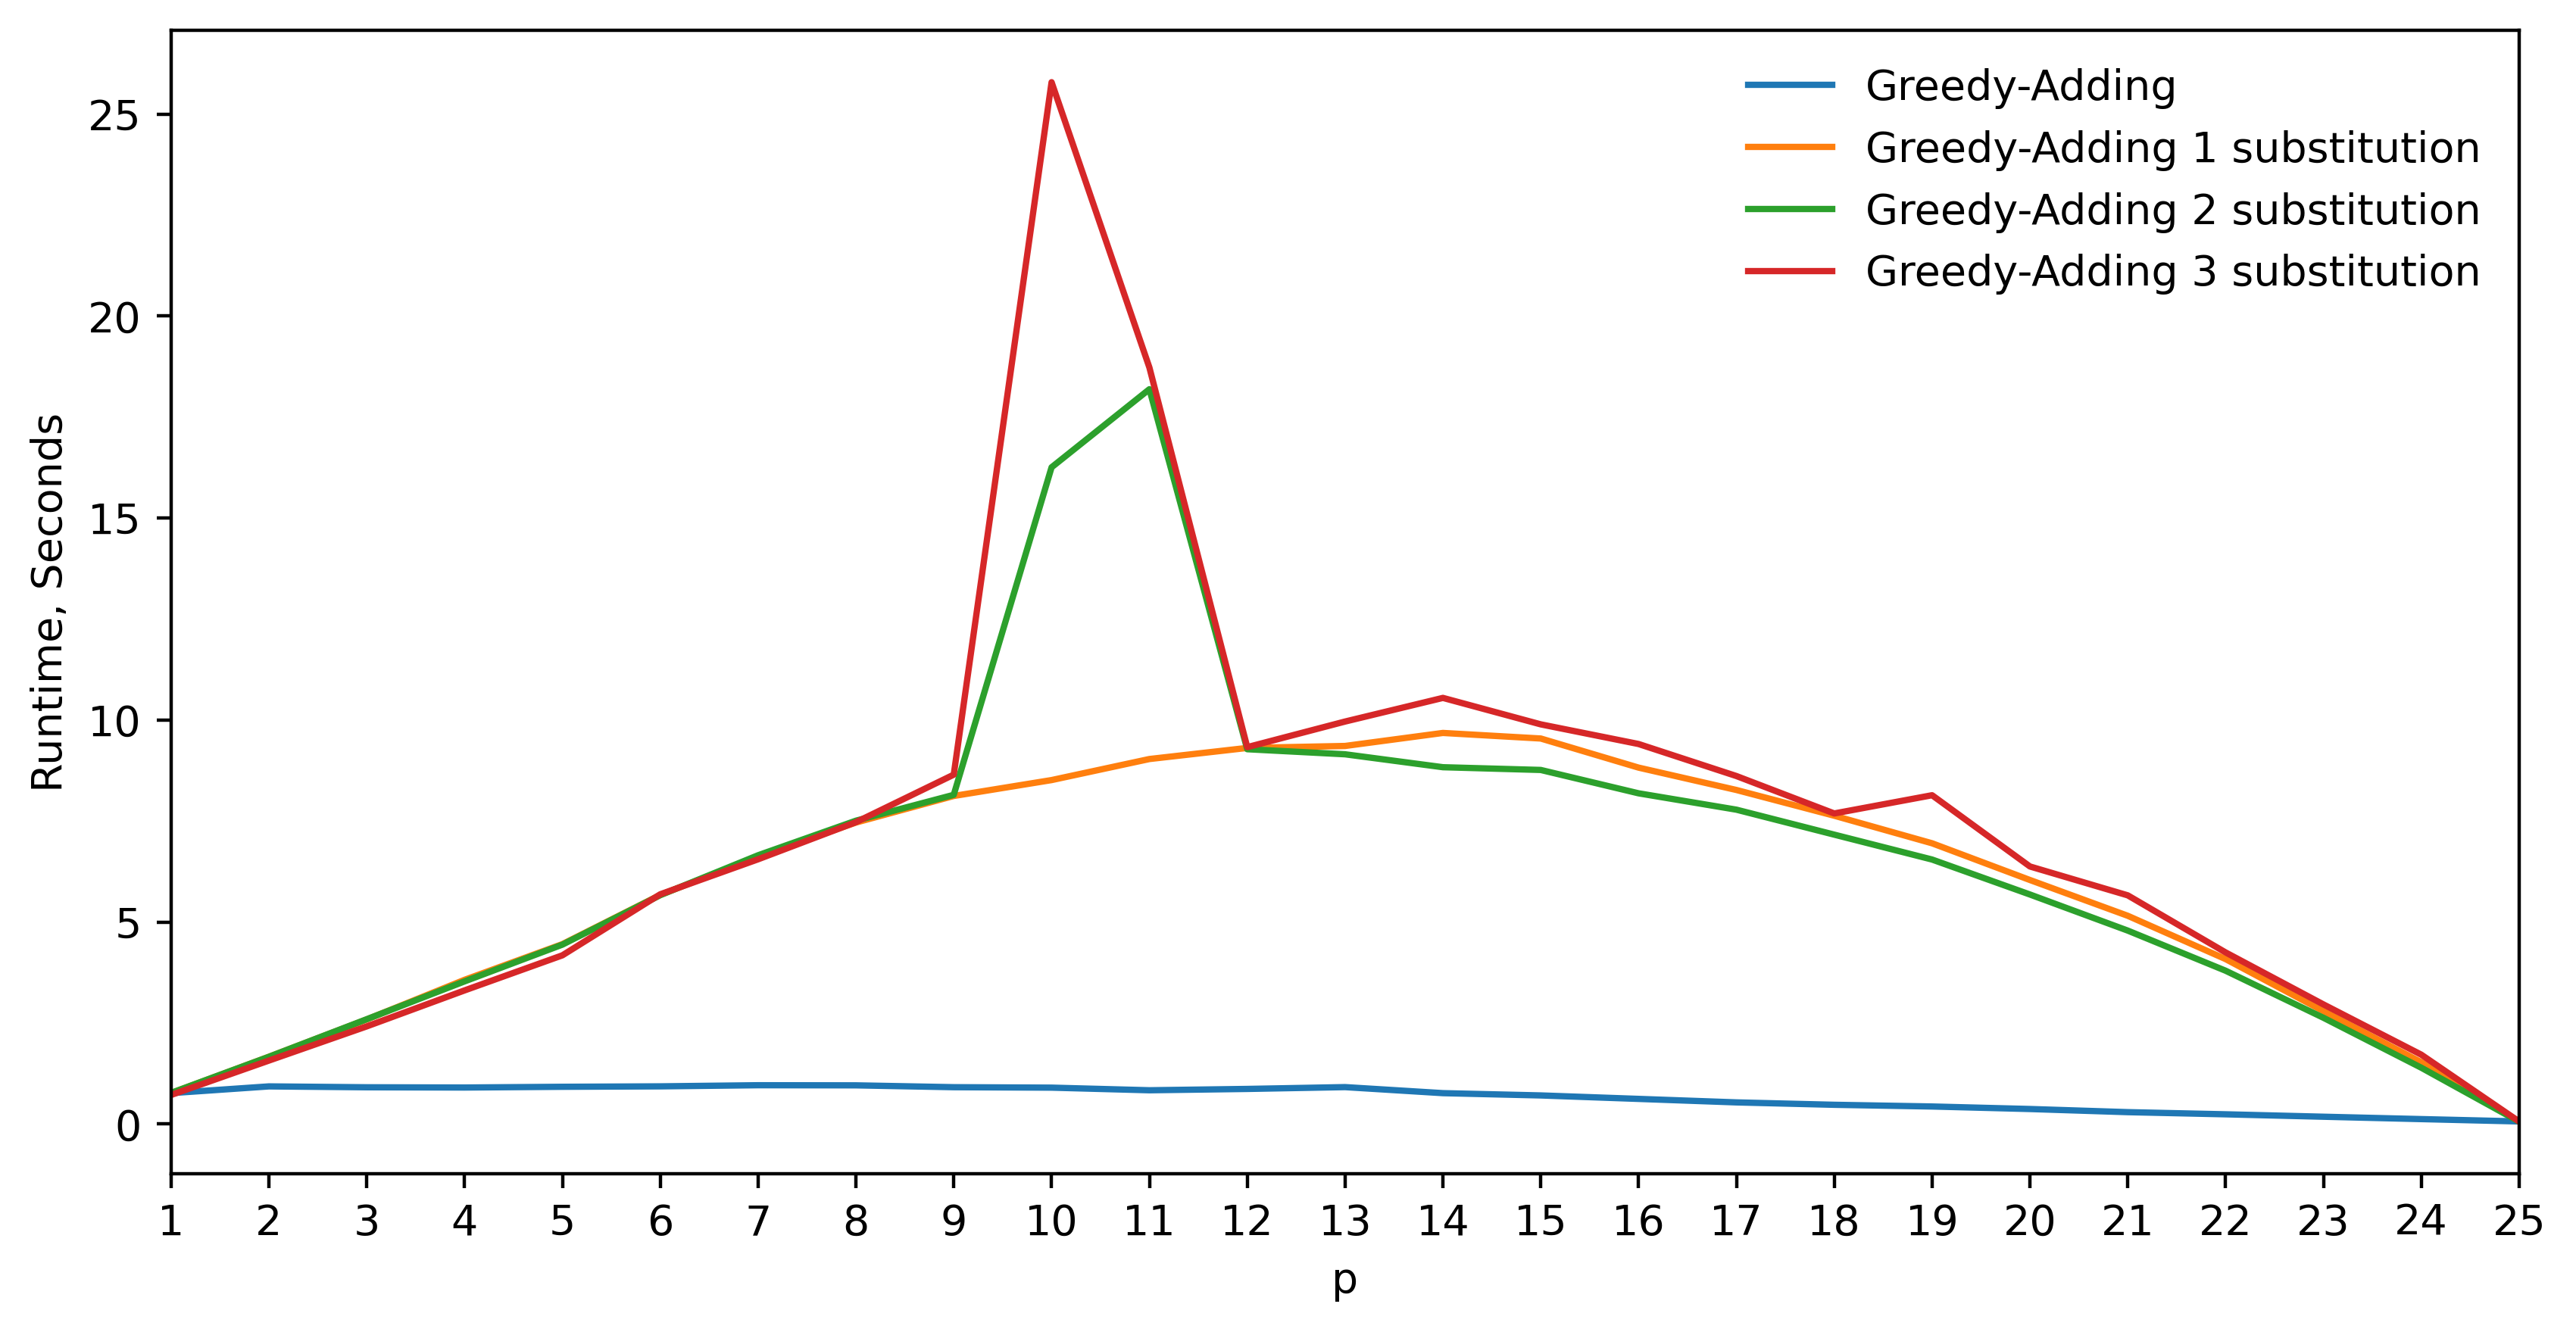

In [176]:
#Only keep up to p=20 as this gives 100%
#plot
plt.figure(figsize=(10,5), dpi=400)
plt.xticks(range(1,26))

plt.rcParams.update({'font.size': 10})
y1 = greedyruntimes[:]
y2 = greedy1runtimes[:]
y3 = greedy2runtimes[:]
y4 = greedy3runtimes[:]
xval = k[:]
ax=plt.plot(xval, y1, label="Greedy-Adding")
plt.plot(xval, y2, label="Greedy-Adding 1 substitution")
plt.plot(xval, y3, label="Greedy-Adding 2 substitution")
plt.plot(xval, y4, label="Greedy-Adding 3 substitution")
plt.xlim([1,25])
plt.legend(frameon=False)
plt.xlabel("p")
plt.ylabel("Runtime, Seconds")
plt.savefig("Data/Figures/Greedyruntimes.png", dpi=400, bbox_inches="tight")